# Проект промышленность

### Описание проекта:

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Необходимо построить модель, которая будет предсказывать температуру сплава.

Заказчик хочет использовать разработанную модель для имитации технологического процесса. 

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

data_arc_new.csv — данные об электродах;

data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

data_gas_new.csv — данные о продувке сплава газом;

data_temp_new.csv — результаты измерения температуры;

data_wire_new.csv — данные о проволочных материалах (объём);

data_wire_time_new.csv — данные о проволочных материалах (время).

Файл `data_arc_new.csv`

key — номер партии;

Начало нагрева дугой — время начала нагрева;

Конец нагрева дугой — время окончания нагрева;

Активная мощность — значение активной мощности;

Реактивная мощность — значение реактивной мощности.

Файл `data_bulk_new.csv`



key — номер партии;

Bulk 1 … Bulk 15 — объём подаваемого материала.

Файл `data_bulk_time_new.csv`


key — номер партии;

Bulk 1 … Bulk 15 — время подачи материала.

Файл data_gas_new.csv

Скачать файл

key — номер партии;

Газ 1 — объём подаваемого газа.

Файл `data_temp_new.csv`


key — номер партии;

Время замера — время замера;

Температура — значение температуры.

Файл `data_wire_new.csv`



key — номер партии;

Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

Файл `data_wire_time_new.csv`


key — номер партии;

Wire 1 … Wire 9 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [1]:
!pip install phik
!pip install --upgrade scikit-learn==1.4
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import (
                      datetime,
                      time)
import datetime as dt
import shap

import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.model_selection import(
    train_test_split,
# загружаем инструменты для автоподбора гиперпараметров    
    RandomizedSearchCV,
    GridSearchCV
)

from sklearn.pipeline import Pipeline

#класс ColumnTransformer работает с данными разного типа в одном наборе 
from sklearn.compose import ColumnTransformer

# загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler                                 
)
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные метрики
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
   
)

from sklearn.multiclass import OneVsRestClassifier
                                                     
from scipy.spatial.distance import (
    cosine,
    euclidean 
)    

# импортируем(загружаем) модели
from sklearn.linear_model import(
    LinearRegression,
    SGDRegressor,
    Lasso,
    Ridge,
    ElasticNet
)
from sklearn.tree import(
    DecisionTreeRegressor
)    
from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor

from sklearn import tree

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
pd.options.mode.chained_assignment = None

In [3]:
RANDOM_STATE = 251124
TEST_SIZE = 0.25

In [4]:
pd.options.display.max_columns = None

##  Загрузка данных

### Данные об электродах

In [5]:
try:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
except:
    data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

In [6]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
data_arc_new.head(2)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438


### Данные о подаче сыпучих материалов (объём)

In [8]:
try:
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
except:
    data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

In [9]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


In [10]:
data_bulk_new.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0


### Данные о подаче сыпучих материалов (время)

In [11]:
try:
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
except:
    data_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

In [12]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


In [13]:
data_bulk_time_new.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39


### Данные о продувке сплава газом

In [14]:
try:
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
except:
    data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

In [15]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [16]:
data_gas_new.head(2)

,key,Газ 1
0,1,29.749986
1,2,12.555561


### Результаты измерения температуры

In [17]:
try:
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
except:
    data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

In [18]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [19]:
data_temp_new.head(2)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


### Данные о проволочных материалах (объём)

In [20]:
try:
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csvv')
except:
    data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

In [21]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [22]:
data_wire_new.head(2)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


data_arc_new.csv — данные об электродах;  
data_bulk_new.csv — данные о подаче сыпучих материалов (объём);  
data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);  
data_gas_new.csv — данные о продувке сплава газом;  
data_temp_new.csv — результаты измерения температуры;  
data_wire_new.csv — данные о проволочных материалах (объём);  
data_wire_time_new.csv — данные о проволочных материалах (время).

### Данные о проволочных материалах (время)

In [23]:
try:
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [24]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [25]:
data_wire_time_new.head(2)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# словарь датафреймов вывод их размеров
dataframes = {
    'data_arc_new':data_arc_new,
    'data_bulk_new': data_bulk_new,
    'data_bulk_new': data_bulk_time_new,
    'data_gas_new': data_gas_new,
    'data_temp_new': data_temp_new,
    'data_wire_new':data_wire_new,
    'data_wire_time_new': data_wire_time_new
       
}
for name, df in dataframes.items():
    print('Датафрейм', name)
    print(df.shape,'\n')

Датафрейм data_arc_new
(14876, 5) 

Датафрейм data_bulk_new
(3129, 16) 

Датафрейм data_gas_new
(3239, 2) 

Датафрейм data_temp_new
(18092, 3) 

Датафрейм data_wire_new
(3081, 10) 

Датафрейм data_wire_time_new
(3081, 10) 



__Вывод__  

Данные успешно загружены.
В полученных данных много пропущенных значений. Пропуски в данных нужно заполнить.   
Время замера содержится в типе данных object для дальнейшей работы с данными нужно преобразовать в datatime.

## Исследовательский анализ и предобработка данных

### Данные об электродах

In [27]:
# Преобразование данных в тип datetime64
data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])
data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'])

In [28]:
data_arc_new.dtypes

key                              int64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
Активная мощность              float64
Реактивная мощность            float64
dtype: object

In [29]:
data_arc_new['heating_duration'] = data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']

In [30]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28


In [31]:
# Выведем процент пропущенных значений для каждого столбца датафрейма
pd.DataFrame(data_arc_new.isna().mean()).sort_values(by=0, ascending=False).style.format('{:.2%}').background_gradient('coolwarm')

,0
key,0.00%
Начало нагрева дугой,0.00%
Конец нагрева дугой,0.00%
Активная мощность,0.00%
Реактивная мощность,0.00%
heating_duration,0.00%


In [32]:
# поиск явных дубликатов
data_arc_new.duplicated().sum() 

0

In [33]:
data_arc_new.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration
count,14876.000000,14876,14876,14876.000000,14876.000000,14876
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986,0 days 00:02:51.670946490
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924,0 days 00:00:11
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175,0 days 00:01:47
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639,0 days 00:02:27
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201,0 days 00:03:34
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,0 days 00:15:07
std,934.571502,NaN,NaN,0.258885,5.873485,0 days 00:01:38.186802680


In [34]:
# Удаление аномальных значений по условию
data_arc_new = data_arc_new.drop(data_arc_new[(data_arc_new['Реактивная мощность'] == -715.479924)].index)

In [35]:
data_arc_new.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration
count,14875.000000,14875,14875,14875.000000,14875.000000,14875
mean,1615.186756,2019-07-05 12:23:40.763025152,2019-07-05 12:26:32.438184960,0.662749,0.487115,0 days 00:02:51.675159663
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777,0 days 00:00:11
25%,806.000000,2019-06-03 23:13:02.500000,2019-06-03 23:16:13,0.467115,0.337190,0 days 00:01:47
50%,1617.000000,2019-07-03 01:28:12,2019-07-03 01:31:27,0.599578,0.441665,0 days 00:02:27
75%,2429.000000,2019-08-07 22:54:16.500000,2019-08-07 22:57:54,0.830135,0.608223,0 days 00:03:34
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,0 days 00:15:07
std,934.593897,NaN,NaN,0.258894,0.197612,0 days 00:01:38.188758501


In [36]:
def gen_color():
    c = lambda: np.random.randint(255)
    return '#{:02x}{:02x}{:02x}'.format(c(), c(), c())

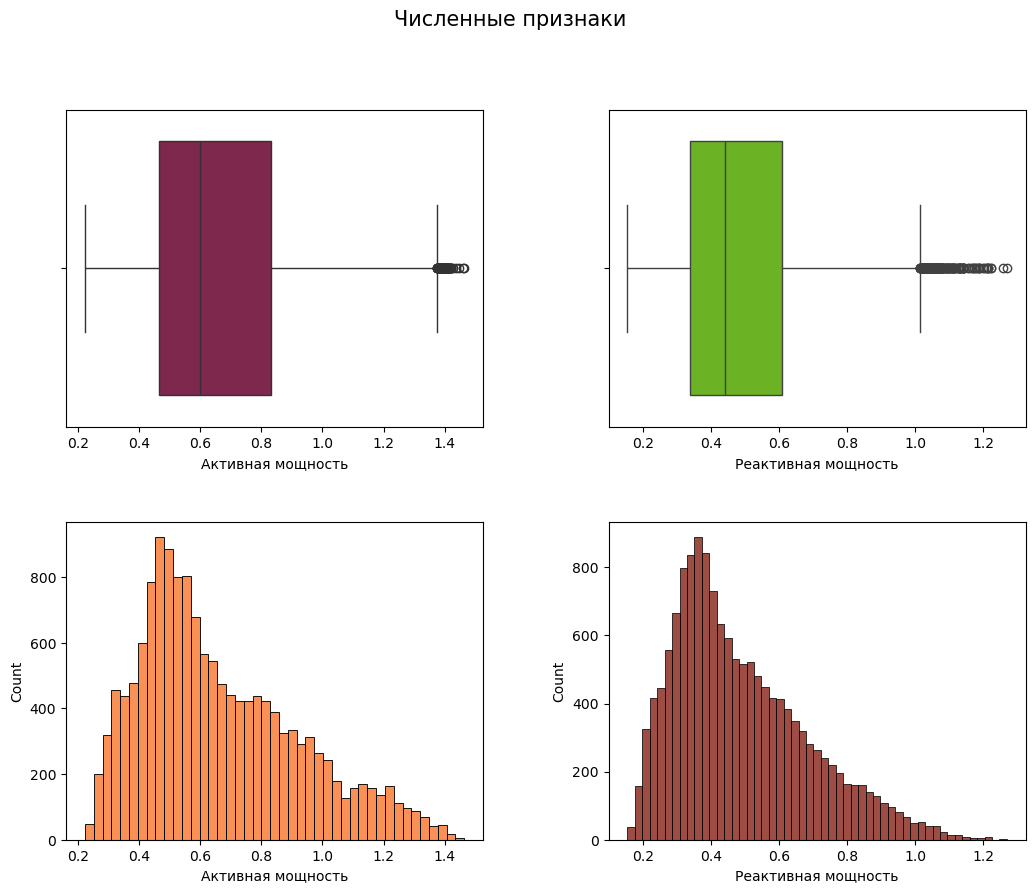

In [37]:
# Создаем таблицу (сетку) размером 4 x 1 ячеек
plt.figure(figsize=(12, 10))

# добавляем общий заголовок
plt.suptitle('Численные признаки', fontsize=15, y=1.1)


grid = GridSpec(2, 2)
# регулировка расстояния между графиками
plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=1.0, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)

plt.subplot(grid[0])
sns.boxplot(data=data_arc_new, x='Активная мощность', color=gen_color())
plt.xlabel('Активная мощность')

plt.subplot(grid[1])
sns.boxplot(data=data_arc_new, x='Реактивная мощность', color=gen_color())
plt.xlabel('Реактивная мощность')

plt.subplot(grid[2])
sns.histplot(data=data_arc_new, x='Активная мощность', color=gen_color())
plt.xlabel('Активная мощность')


plt.subplot(grid[3])
sns.histplot(data=data_arc_new, x='Реактивная мощность', color=gen_color())
plt.xlabel('Реактивная мощность')

plt.show()

Text(0, 0.5, 'Плотность встречаемости значений')

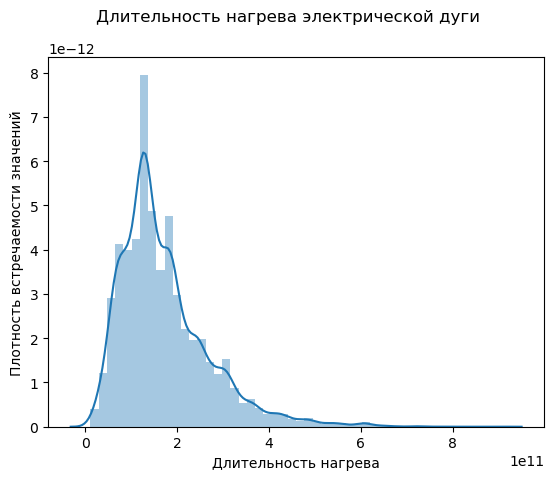

In [38]:
plt.suptitle('Длительность нагрева электрической дуги')

sns.distplot(data_arc_new['heating_duration'])
plt.xlabel('Длительность нагрева')
plt.ylabel('Плотность встречаемости значений')

In [39]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28


In [40]:
# преобразование типа timedelta в общее число секунд
data_arc_new["heating_duration"] = pd.to_timedelta(data_arc_new['heating_duration']).dt.total_seconds()

In [41]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


In [42]:
data_arc_new.dtypes

key                              int64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
Активная мощность              float64
Реактивная мощность            float64
heating_duration               float64
dtype: object

**Вывод**
Получен датафрейм **данных об электродах** 

- `key`                   int64  
- `Начало нагрева дугой`  object 
- `Конец нагрева дугой`   object 
- `Активная мощность`     float64
- `Реактивная мощность`   float64

В данных нет пропусков.  
Распределение данных по численным признакам нормальное, с выраженным правым хвостом.   
Начало нагрева дугой и конец нагрева дугой преобразовали в тип данных datetime64 и создали новый столбец длительность нагрева дугой(heating_duration).   
У получившихся данных по длительности нагрева распределение нормальное с правым хвостом.

### Данные о подаче сыпучих материалов (объём)

In [43]:
data_bulk_new.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


In [44]:
# Выведем процент пропущенных значений для каждого столбца датафрейма
pd.DataFrame(data_bulk_new.isna().mean()).sort_values(by=0, ascending=False).style.format('{:.2%}').background_gradient('coolwarm')

,0
Bulk 8,99.97%
Bulk 13,99.42%
Bulk 9,99.39%
Bulk 2,99.30%
Bulk 7,99.20%
Bulk 5,97.54%
Bulk 10,94.38%
Bulk 11,94.34%
Bulk 1,91.95%
Bulk 6,81.59%


In [45]:
# поиск явных дубликатов
data_bulk_new.duplicated().sum() 

0

In [46]:
data_bulk_new.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

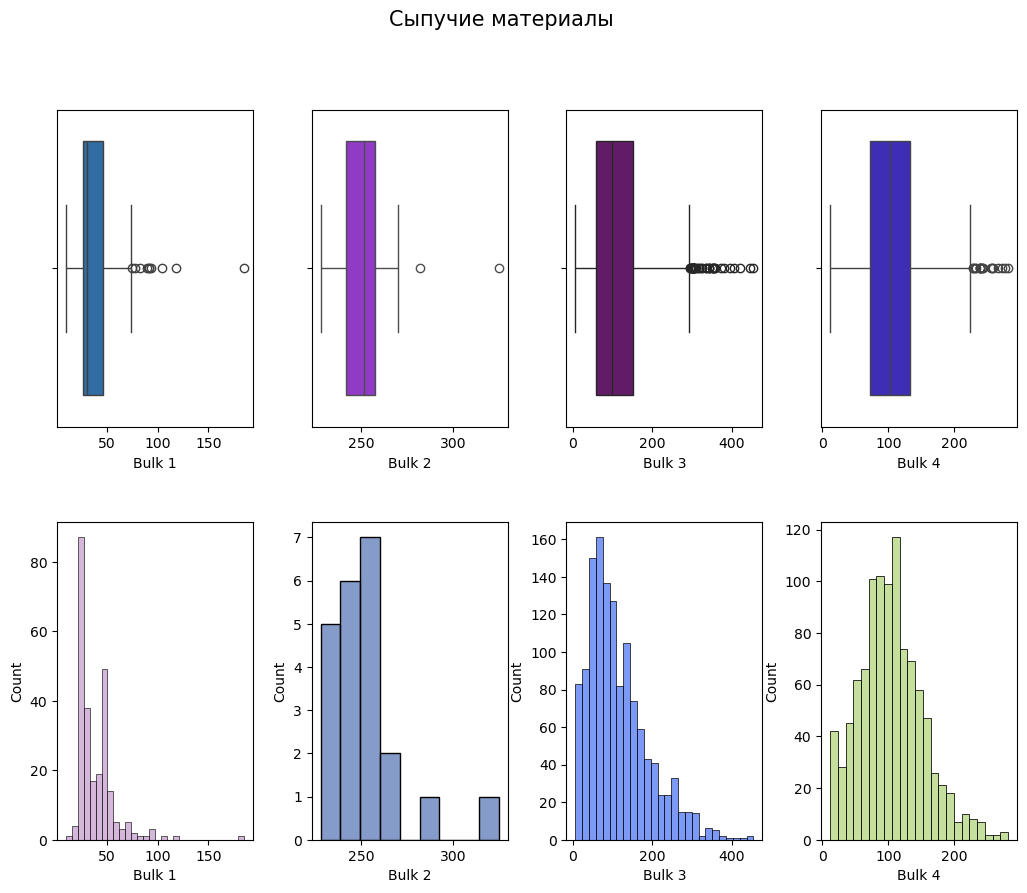

In [47]:
def graphics(df, layout=(2,4), text=''):
    # Создаем таблицу (сетку) размером 4 x 1 ячеек
    plt.figure(figsize=(12, 10))

    # добавляем общий заголовок
    plt.suptitle(text, fontsize=15, y=1.1)


    grid = GridSpec(*layout)# распаковка tuple 
    # регулировка расстояния между графиками
    plt.subplots_adjust(left=0.13, 
                        right=0.93, 
                        top=1.0, 
                        bottom= 0.27, 
                        wspace= 0.3, 
                        hspace=0.3)
    for i,col in enumerate(df.columns):

        plt.subplot(grid[i])
        sns.boxplot(data=df, x=col, color=gen_color())
        plt.xlabel(col)
        
        plt.subplot(grid[i+layout[1]])# второй элемент layout
        sns.histplot(data=df, x=col, color=gen_color())
        plt.xlabel(col)

    plt.show()  

graphics(df=data_bulk_new[['Bulk 1','Bulk 2','Bulk 3','Bulk 4']], layout= (2,4), text='Сыпучие материалы') 

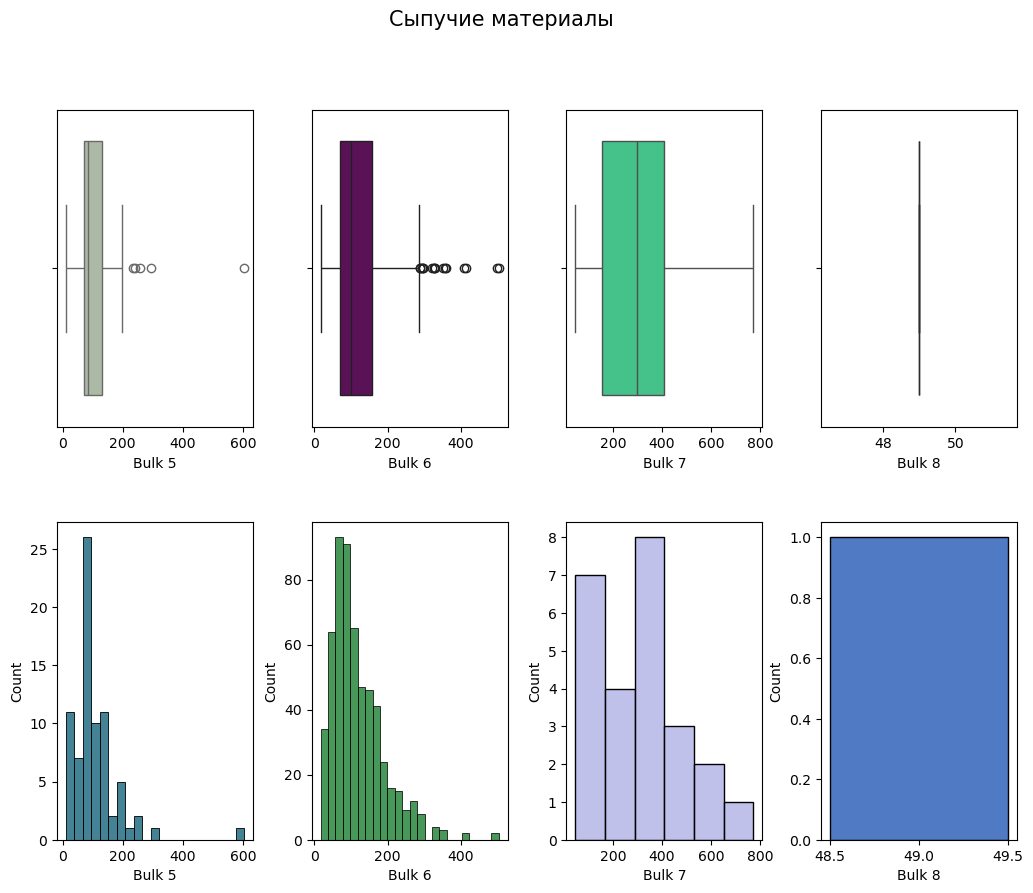

In [48]:
graphics(df=data_bulk_new[['Bulk 5','Bulk 6','Bulk 7','Bulk 8']], layout= (2,4), text='Сыпучие материалы')

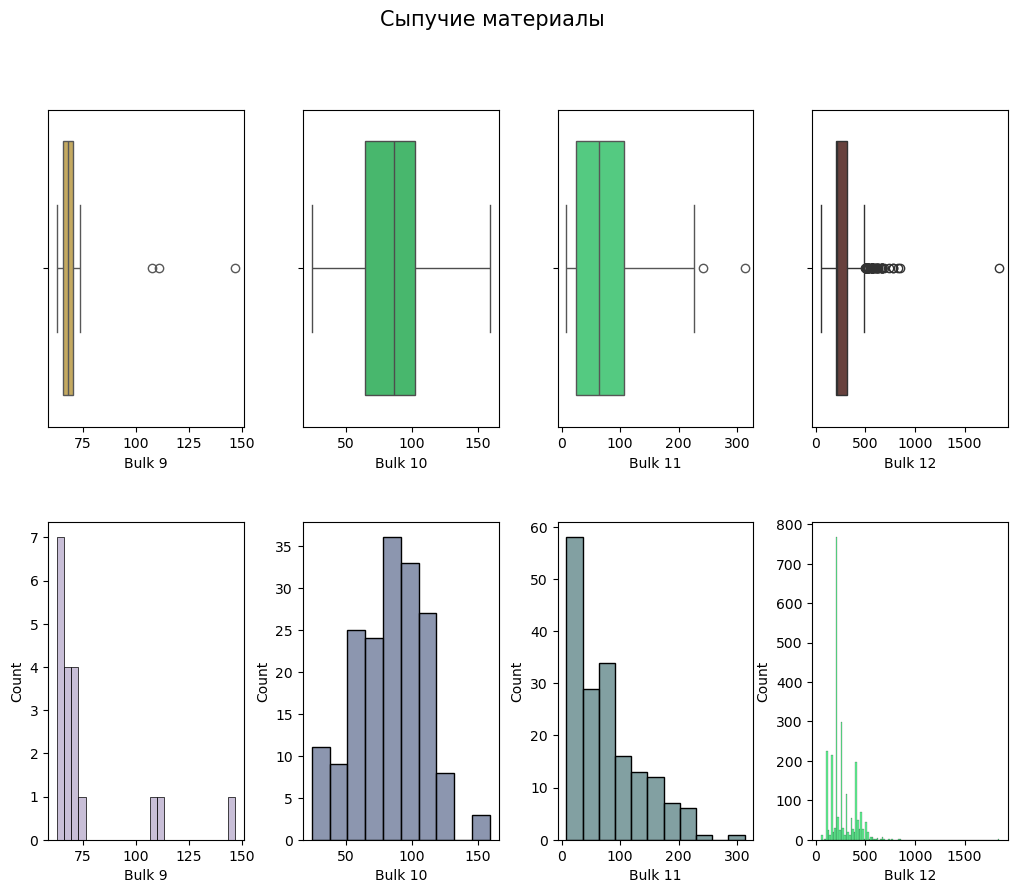

In [49]:
graphics(df=data_bulk_new[['Bulk 9','Bulk 10','Bulk 11','Bulk 12']], layout= (2,4), text='Сыпучие материалы')   

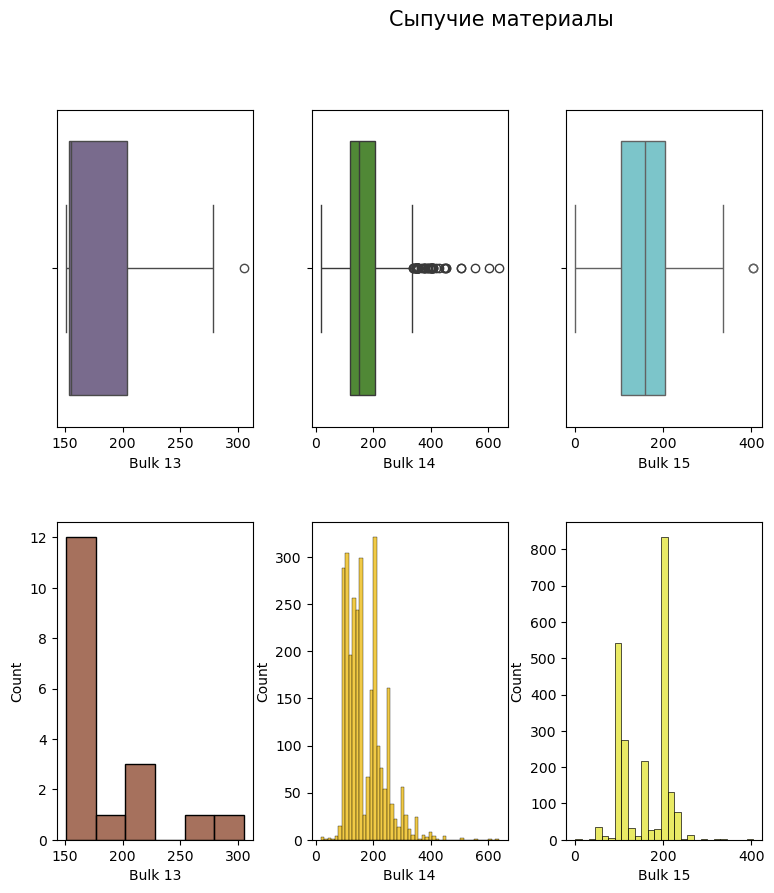

In [50]:
graphics(df=data_bulk_new[['Bulk 13','Bulk 14','Bulk 15']], layout= (2,4), text='Сыпучие материалы')   

In [51]:
print(f'Размер датасета до изменения: {data_bulk_new.shape}')
data_bulk_new.fillna(0, inplace=True)
print(f'Размер датасета до изменения: {data_bulk_new.shape}')

Размер датасета до изменения: (3129, 16)
Размер датасета до изменения: (3129, 16)


In [52]:
# проверка на дубликаты
data_bulk_new.duplicated().sum()

0

In [53]:
# количество пропусков
data_bulk_new.isna().sum()

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

**Вывод**  
Получен датафрейм `data_bulk_new`
Типы данных датафрейма 
key int64    
Bulk 1float64;  
Bulk 2 float64;  
Bulk 3 float64;  
Bulk 4 float64;  
Bulk 5 float64;  
Bulk 6 float64;  
Bulk 7 float64;  
Bulk 8 float64;  
Bulk 9 float64;  
Bulk 10 float64;  
Bulk 11 float64;  
Bulk 12 float64;  
Bulk 13 float64;  
Bulk 14 float64;  
Bulk 15 float64.  

Bulk1-Bulk 15 типы присадок, если присадку не добавляли в данный момент времени, значит она не нужна, поэтому заменим не числовы значения 0.  В данных о сыпучих материалах есть выбросы на мой взгляд они не критичны на этом этапе оставим данные без изменений. Т.к. может быть что на этапе добавления присадок нужен был больший объем для нормализации химического состава.


### Данные о подаче сыпучих материалов (время)

In [54]:
data_bulk_time_new.sample(1)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
491,518,NaN,NaN,NaN,2019-05-23 07:38:51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-23 07:28:07,NaN,2019-05-23 07:20:39,2019-05-23 07:12:53


In [55]:
data_bulk_time_new.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [56]:
# Выведем процент пропущенных значений для каждого столбца датафрейма
pd.DataFrame(data_bulk_time_new.isna().mean()).sort_values(by=0, ascending=False).style.format('{:.2%}').background_gradient('coolwarm')

,0
Bulk 8,99.97%
Bulk 13,99.42%
Bulk 9,99.39%
Bulk 2,99.30%
Bulk 7,99.20%
Bulk 5,97.54%
Bulk 10,94.38%
Bulk 11,94.34%
Bulk 1,91.95%
Bulk 6,81.59%


In [57]:
print(f'Размер датасета до изменения: {data_bulk_new.shape}')
data_bulk_time_new.fillna(0, inplace=True)
print(f'Размер датасета до изменения: {data_bulk_new.shape}')

Размер датасета до изменения: (3129, 16)
Размер датасета до изменения: (3129, 16)


In [58]:
# количество пропущенных значений 
data_bulk_time_new.isna().sum()

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

**Вывод**  
Получен датафрейм `data_bulk_time_new` с данными о времени добавления присадки
Типы данных столбцов  key int64 
Bulk 1 тип данных object;
Bulk 2 object;
Bulk 3 object;
Bulk 4 object;
Bulk 5 object;
Bulk 6 object;
Bulk 7 object;
Bulk 8 object;
Bulk 9 object;
Bulk 10 object;
Bulk 11 object;
Bulk 12 object;
Bulk 13 object;
Bulk 14 object;
Bulk 15 object.

В данных были пропуски, руководствуясь рассуждениями по заполнению проппусков о результатах подачи сыпучих материалов объем, заполнили пропущенные значения 0. Т.к. в данной задаче мы не можем влиять на химический процесс добавления присадок, считаю, что данные о времени их добавления излишни.

### Данные о продувке сплава газом

In [59]:
data_gas_new.sample(1)

,key,Газ 1
717,720,18.466793


In [60]:
data_gas_new.dtypes

key        int64
Газ 1    float64
dtype: object

In [61]:
pd.DataFrame(data_gas_new.isna().mean()).sort_values(by=0, ascending=False).style.format('{:.2%}').background_gradient('coolwarm')

,0
key,0.00%
Газ 1,0.00%


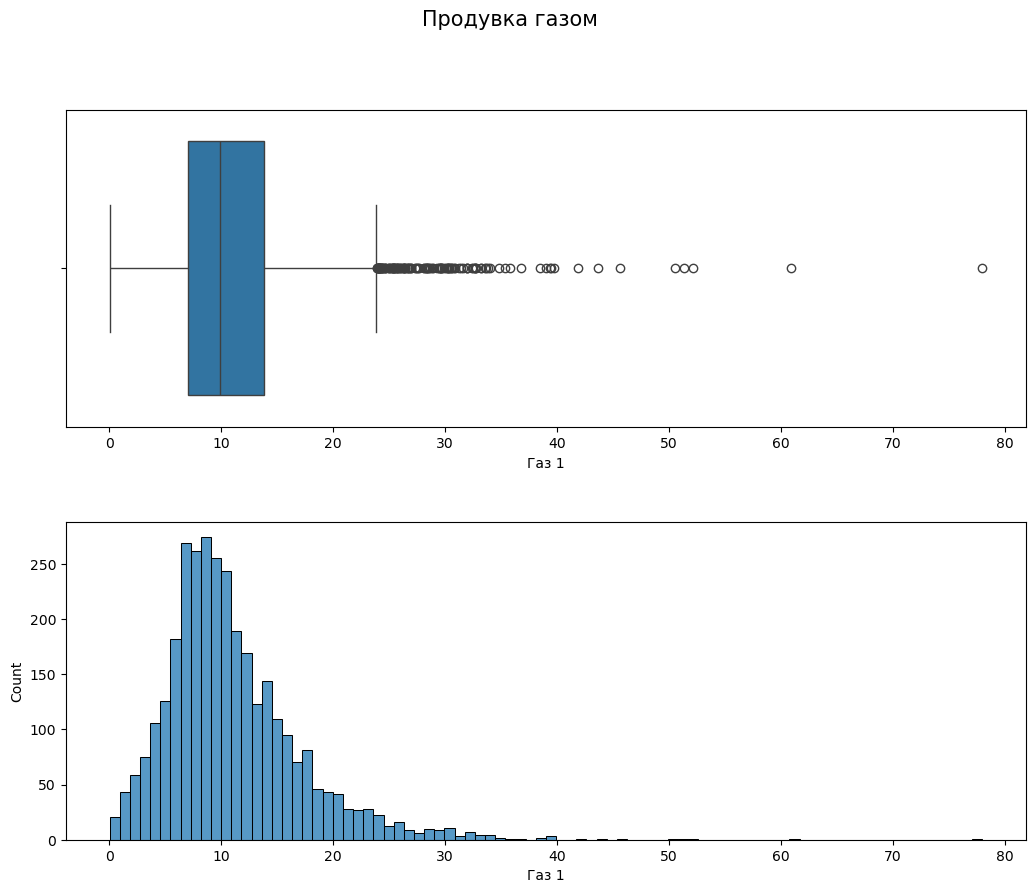

In [62]:
def signs(df, text=''):
# Создаем таблицу (сетку) размером 4 x 1 ячеек
    plt.figure(figsize=(12, 10))

    # добавляем общий заголовок
    plt.suptitle(text, fontsize=15, y=1.1)


    grid = GridSpec(2, 1)
    # регулировка расстояния между графиками
    plt.subplots_adjust(left=0.13, 
                        right=0.93, 
                        top=1.0, 
                        bottom= 0.27, 
                        wspace= 0.3, 
                        hspace=0.3)

    plt.subplot(grid[0])
    sns.boxplot(x=df, orient=90)

    plt.subplot(grid[1])
    sns.histplot(data=df)
    plt.plot()
    
signs(df=data_gas_new['Газ 1'], text='Продувка газом')    

**Вывод**  
Получен датафрейм о продувке сплава газом `data_gas_new`
key int64;
Газ 1 float64.

Продувка используется в том числе для перемешивания смеси.   
Данные распределены нормально в данных есть выбросы, на данном этапе оставим их без изменения.

### Результаты измерения температуры

In [63]:
data_temp_new.dtypes

key               int64
Время замера     object
Температура     float64
dtype: object

In [64]:
pd.DataFrame(data_temp_new.isna().mean()).sort_values(by=0, ascending=False).style.format('{:.2%}').background_gradient('coolwarm')

,0
Температура,18.94%
key,0.00%
Время замера,0.00%


In [65]:
data_temp_new.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [66]:
data_temp_new.head(2)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


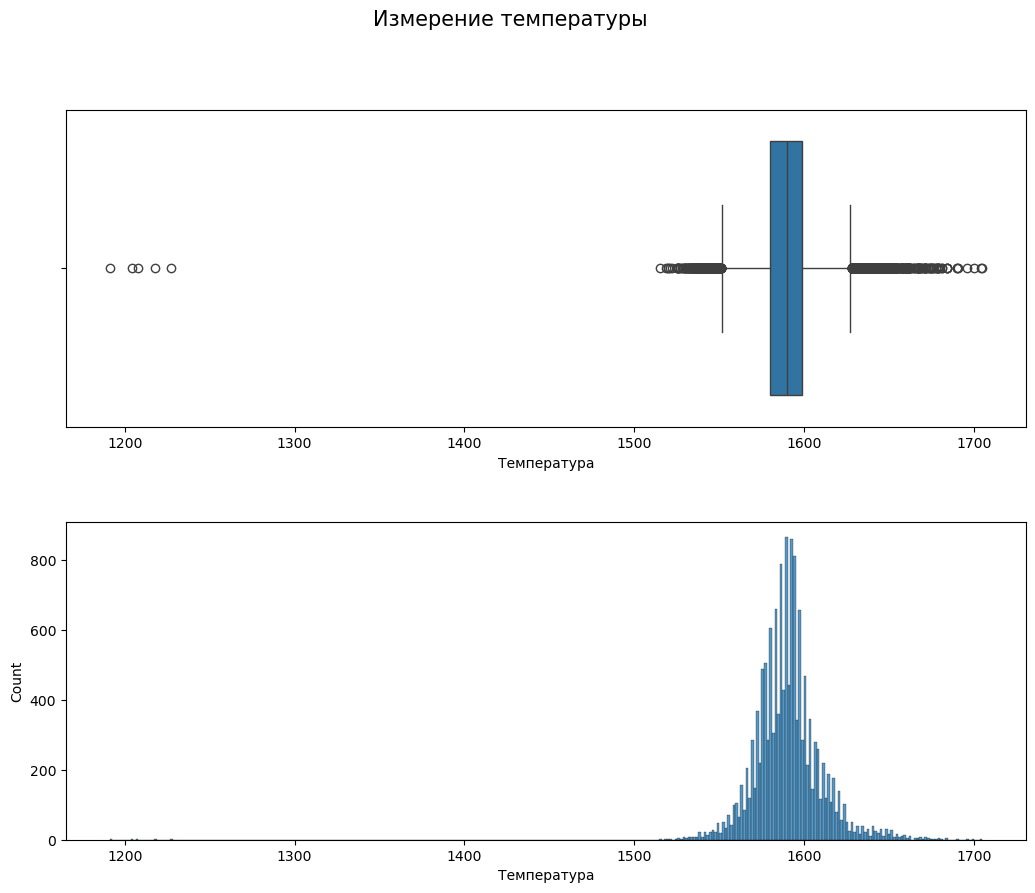

In [67]:
signs(df=data_temp_new['Температура'], text='Измерение температуры') 

In [68]:
def datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col])
        
datetime(df=data_wire_time_new, columns=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'])

In [69]:
data_wire_time_new.dtypes

key                int64
Wire 1    datetime64[ns]
Wire 2    datetime64[ns]
Wire 3    datetime64[ns]
Wire 4    datetime64[ns]
Wire 5    datetime64[ns]
Wire 6    datetime64[ns]
Wire 7    datetime64[ns]
Wire 8    datetime64[ns]
Wire 9    datetime64[ns]
dtype: object

**Вывод**  
Получены данные об измерениях температуры data_wire_time_new
Типы данных
key        int64;  
Wire 1    object;  
Wire 2    object;  
Wire 3    object;  
Wire 4    object;  
Wire 5    object;  
Wire 6    object;  
Wire 7    object;  
Wire 8    object;  
Wire 9    object.  

Если есть измерение конечной температуры, значит исследуемый материал достиг целевого химического состава и оптимальной температуры, т.е. пригоден для производства готового продукта заготовки-сляба.  Следовательно нас интересует только начальное измерение температуры и конечное измерение в качестве целевого признака.

### Данные о проволочных материалах (объём)

In [70]:
data_wire_new.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [71]:
data_wire_new.dtypes

key         int64
Wire 1    float64
Wire 2    float64
Wire 3    float64
Wire 4    float64
Wire 5    float64
Wire 6    float64
Wire 7    float64
Wire 8    float64
Wire 9    float64
dtype: object

In [72]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [73]:
# Выведем процент пропущенных значений для каждого столбца датафрейма
pd.DataFrame(data_wire_new.isna().mean()).sort_values(by=0, ascending=False).style.format('{:.2%}').background_gradient('coolwarm')

,0
Wire 5,99.97%
Wire 7,99.64%
Wire 4,99.55%
Wire 8,99.38%
Wire 9,99.06%
Wire 3,97.96%
Wire 6,97.63%
Wire 2,64.98%
Wire 1,0.84%
key,0.00%


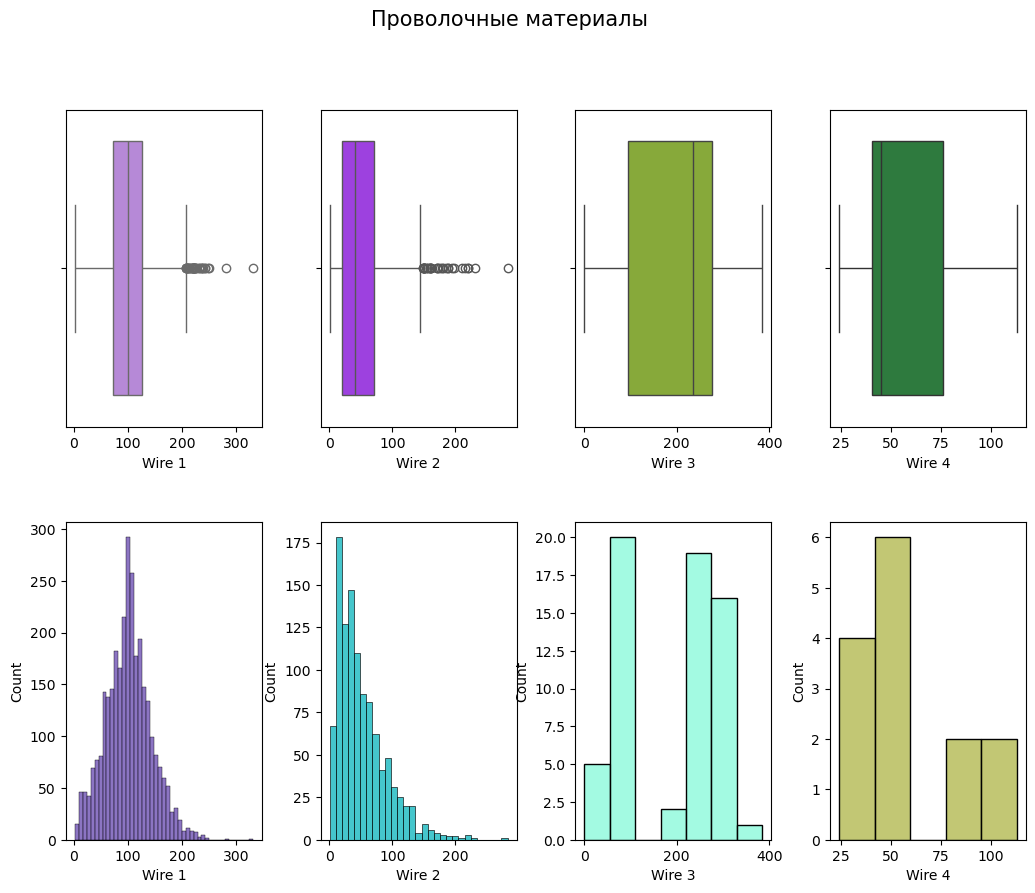

In [74]:
graphics(df=data_wire_new[['Wire 1','Wire 2','Wire 3','Wire 4']], layout= (2,4), text='Проволочные материалы')  

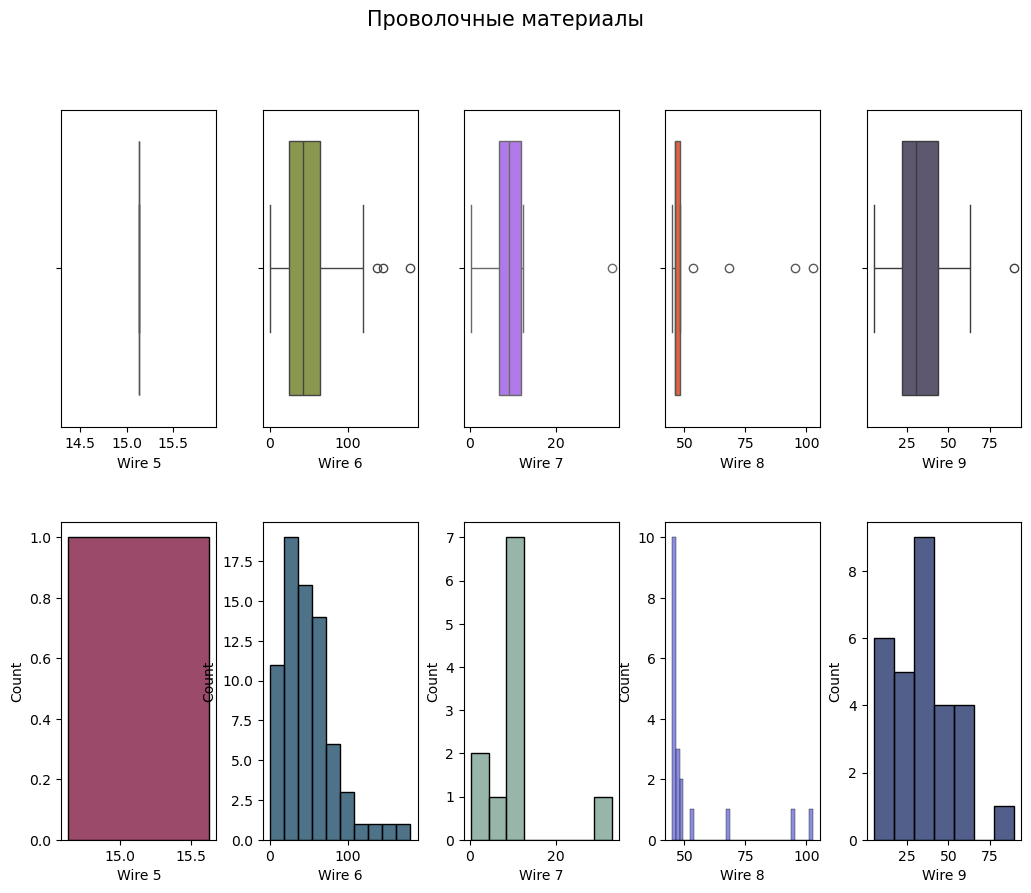

In [75]:
graphics(df=data_wire_new[['Wire 5','Wire 6','Wire 7','Wire 8', 'Wire 9']], layout= (2,5), text='Проволочные материалы') 

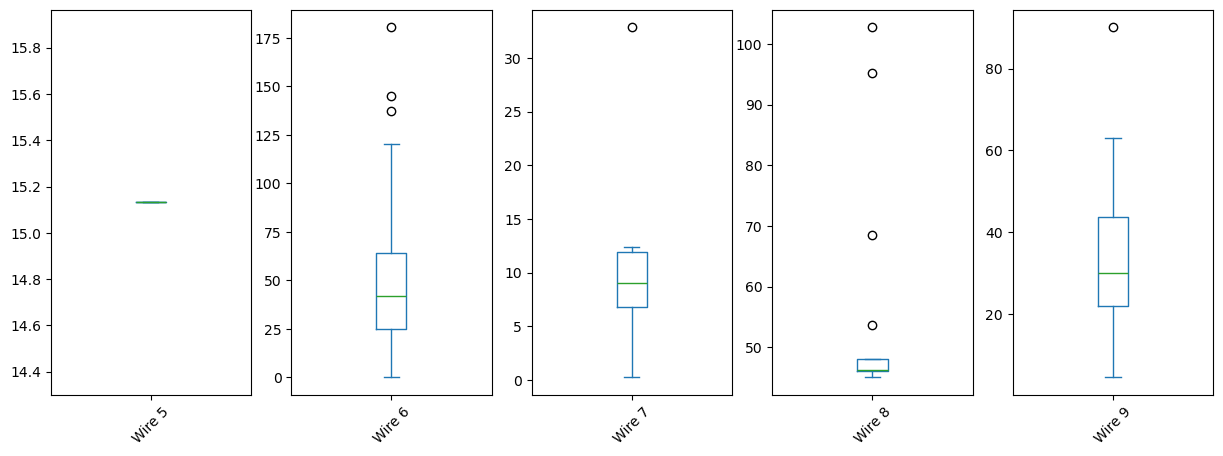

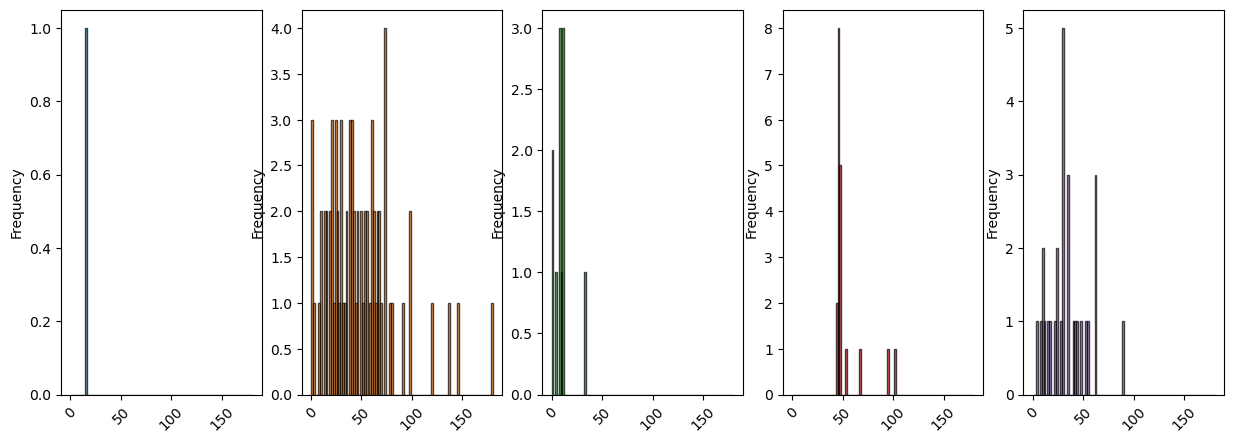

In [76]:
#  применим метод .plot() кстолбцам датафрейма
data_wire_new[['Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']].plot(subplots = True,   # укажем, что хотим создать подграфики
           layout = (1,5),    # пропишем размерность сетки
           kind = 'box',      # укажем тип графика
           figsize = (15,5),   # зададим размер фигуры
                 
           grid = False,      # уберем сетку
           legend = False,    # уберем легенду
           rot = 45);         # повернем подписи к делениям по оси x на 45 градусов

data_wire_new[['Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']].plot(subplots = True,   # укажем, что хотим создать подграфики
           layout = (1,5),    # пропишем размерность сетки
           kind = 'hist',      # укажем тип графика
           figsize = (15,5),   # зададим размер фигуры
           bins=100,
           edgecolor='black',  # цвет границы                                             
           alpha=0.7,                                               
           grid = False,      # уберем сетку
           legend = False,    # уберем легенду
           rot = 45);         # повернем подписи к делениям по оси x на 45 градусов

In [77]:
print(f'Размер датасета до изменения: {data_wire_new.shape}')
data_wire_new.fillna(0, inplace=True)
print(f'Размер датасета до изменения: {data_wire_new.shape}')

Размер датасета до изменения: (3081, 10)
Размер датасета до изменения: (3081, 10)


In [78]:
data_wire_new.isna().sum()

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

**Вывод**  
Получен датафрейм о проволочных материалах `data_wire_new`
Тип данных
key         int64;  
Wire 1    float64;  
Wire 2    float64;  
Wire 3    float64;  
Wire 4    float64;  
Wire 5    float64;  
Wire 6    float64;  
Wire 7    float64;  
Wire 8    float64;  
Wire 9    float64.    
Большое количество пропущенных значений заменим их 0. Т.к. если пропуск, следовательно проволока не добавлялась в состав. Не все данные распределены нормально. Выбросы на данном этапе оставим.

### Данные о проволочных материалах (время)

In [79]:
data_wire_time_new.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [80]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [81]:
datetime(df=data_wire_time_new, columns=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'])

In [82]:
data_wire_time_new.dtypes

key                int64
Wire 1    datetime64[ns]
Wire 2    datetime64[ns]
Wire 3    datetime64[ns]
Wire 4    datetime64[ns]
Wire 5    datetime64[ns]
Wire 6    datetime64[ns]
Wire 7    datetime64[ns]
Wire 8    datetime64[ns]
Wire 9    datetime64[ns]
dtype: object

In [83]:
print(f'Размер датасета до изменения: {data_bulk_new.shape}')
data_wire_time_new.fillna(0, inplace=True)
print(f'Размер датасета до изменения: {data_bulk_new.shape}')

Размер датасета до изменения: (3129, 16)
Размер датасета до изменения: (3129, 16)


In [84]:
data_wire_time_new.isna().sum()

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

**Вывод**  
Получили датафрейм data_wire_time_new о времени заполнения проволочных материалах.  
Преобразовали данные в тип datetime64, заполнили пропуски в данных 0.

##  Объединение данных

Объедините выбранные вами признаки в один датафрейм по ключу.

In [85]:
data_arc_new.head(2)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0


In [86]:
agg_func_math = {
    'Активная мощность': 'sum',
    'Реактивная мощность': 'sum',
    'heating_duration': 'sum'
    
}
data_arc_new_sum = data_arc_new.groupby(['key']).agg(agg_func_math).round(2)

In [87]:
data_arc_new_sum.head(7)

,Активная мощность,Реактивная мощность,heating_duration
key,,,
1,3.04,2.14,1098.0
2,2.14,1.45,811.0
3,4.06,2.94,655.0
4,2.71,2.06,741.0
5,2.25,1.69,869.0
6,2.73,1.88,952.0
7,2.63,1.96,673.0


In [88]:
# проверка перед объедиением
# есть ли еще несколько одинаковых параметров key в данных 
# словарь датафреймов
dataframes = {
    'data_bulk_new': data_bulk_new,
    'data_bulk_new': data_bulk_time_new,
    'data_gas_new': data_gas_new,
    'data_temp_new': data_temp_new,
    'data_wire_new':data_wire_new,
    'data_wire_time_new': data_wire_time_new
       
}
for name, df in dataframes.items():
    print('Датафрейм', name)
    display(df.head(2))

Датафрейм data_bulk_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39


Датафрейм data_gas_new


,key,Газ 1
0,1,29.749986
1,2,12.555561


Датафрейм data_temp_new


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


Датафрейм data_wire_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Датафрейм data_wire_time_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:36:50,0,0,0,0,0,0,0,0


In [89]:
# удалим колонку
data_temp_new = data_temp_new.drop(columns=['Время замера'])

In [90]:
# выделение первых значений по ключу
data_temp_new_gr_head = data_temp_new.groupby(['key']).head(1)
print('Размер data_temp_new', data_temp_new_gr_head.shape)
data_temp_new_gr_head.head(3)

Размер data_temp_new (3216, 2)


,key,Температура
0,1,1571.0
6,2,1581.0
11,3,1596.0


In [91]:
# выделение конечных значений по ключу
data_temp_new_gr_tail = data_temp_new.groupby(['key']).tail(1)
print(data_temp_new_gr_tail.shape)
data_temp_new_gr_tail.head(3)

(3216, 2)


,key,Температура
5,1,1613.0
10,2,1602.0
16,3,1599.0


In [92]:
data_temp_new_gr_tail = data_temp_new_gr_tail.rename(columns={'Температура': 'Температура_end'
                                                              })
data_temp_new_gr_tail.head(3)

,key,Температура_end
5,1,1613.0
10,2,1602.0
16,3,1599.0


In [93]:
# объединение датафреймов 
data_temp_new_gr_merge = data_temp_new_gr_head.merge(data_temp_new_gr_tail, on='key', how='left')
print('')
print('Размер таблицы данных о температуре', data_temp_new_gr_merge.shape)

data_temp_new_gr_merge.head(3)


Размер таблицы данных о температуре (3216, 3)


,key,Температура,Температура_end
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0


In [94]:
# проверка перед объедиением
# есть ли еще несколько одинаковых параметров key в данных 
# словарь датафреймов
dataframes = {
#     'data_arc_new_gr_merge':data_arc_new_gr_merge,
    'data_bulk_new': data_bulk_new,
    'data_bulk_new': data_bulk_time_new,
    'data_gas_new': data_gas_new,
    'data_temp_new_gr_merge': data_temp_new_gr_merge,
    'data_wire_new':data_wire_new,
    'data_wire_time_new': data_wire_time_new
       
}
for name, df in dataframes.items():
    print('Датафрейм', name)
    print(df.shape,'\n')

Датафрейм data_bulk_new
(3129, 16) 

Датафрейм data_gas_new
(3239, 2) 

Датафрейм data_temp_new_gr_merge
(3216, 3) 

Датафрейм data_wire_new
(3081, 10) 

Датафрейм data_wire_time_new
(3081, 10) 



In [95]:
# объединим данные датафреймов по ключу key
data = data_arc_new_sum.merge(data_temp_new_gr_merge, on='key', how='left')
data = data.merge(data_gas_new, on='key',  how='inner')
data = data.merge(data_bulk_new, on='key', how='inner')
data = data.merge(data_wire_new, on='key', how='inner')
print('')
print('Размер таблицы', data.shape)
data.head(2)


Размер таблицы (3022, 31)


,key,Активная мощность,Реактивная мощность,heating_duration,Температура,Температура_end,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,3.04,2.14,1098.0,1571.0,1613.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2.14,1.45,811.0,1581.0,1602.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  Исследовательский анализ и предобработка данных объединённого датафрейма

In [96]:
# Выведем процент пропущенных значений для каждого столбца датафрейма
pd.DataFrame(data.isna().mean()).sort_values(by=0, ascending=False).style.format('{:.2%}').background_gradient('coolwarm')

,0
Температура_end,22.93%
key,0.00%
Bulk 10,0.00%
Wire 8,0.00%
Wire 7,0.00%
Wire 6,0.00%
Wire 5,0.00%
Wire 4,0.00%
Wire 3,0.00%
Wire 2,0.00%


In [97]:
data['S'] = ((data['Активная мощность']**2 + data['Реактивная мощность']**2)**0.5)
data['cos'] = (data['Активная мощность']/data['S'])
# data.rename(columns={'Активная мощность': 'S'}, inplace=True)

In [98]:
data.head(2)

,key,Активная мощность,Реактивная мощность,heating_duration,Температура,Температура_end,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,S,cos
0,1,3.04,2.14,1098.0,1571.0,1613.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.717687,0.817713
1,2,2.14,1.45,811.0,1581.0,1602.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.584976,0.827861


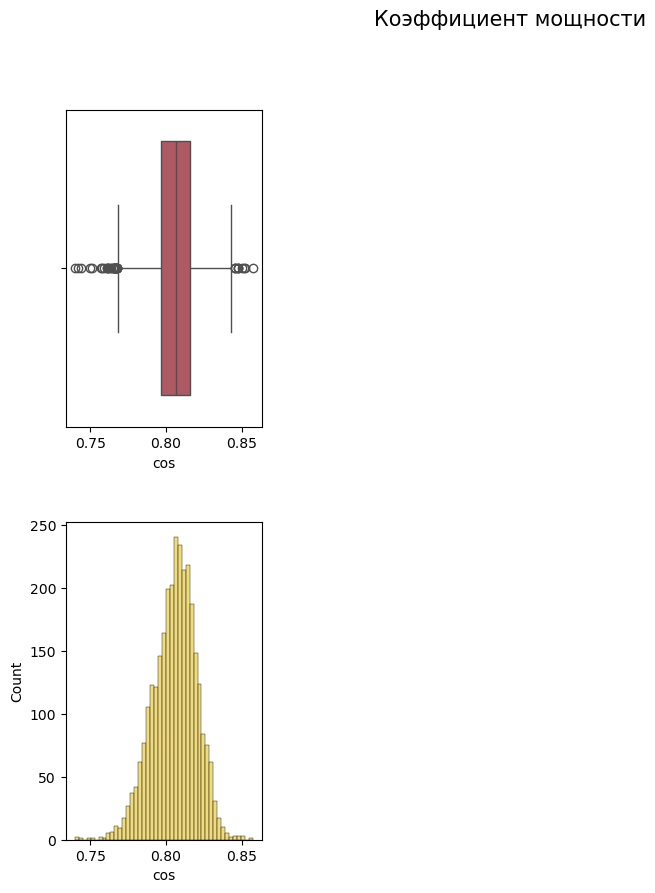

In [99]:
graphics(df=data[['cos']], layout= (2,4), text='Коэффициент мощности') 

Косинус фи лежит в границах [0,1] , введем новый признак, надеюсь он улучшит нашу метрику

In [100]:
data.columns

Index(['key', 'Активная мощность', 'Реактивная мощность', 'heating_duration',
       'Температура', 'Температура_end', 'Газ 1', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
       'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1',
       'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8',
       'Wire 9', 'S', 'cos'],
      dtype='object')

In [101]:
# удаление пропущенных значений
data = data.dropna(subset=['Температура_end'])

In [102]:
# если время добавления смеси не учитываем, то посчитаем результирующие значения Bulk и Ware

data['Wire'] = data[['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5',
                     'Wire 6','Wire 7','Wire 8','Wire 9']].sum(axis=1)

data['Bulk'] = data[['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4','Bulk 5','Bulk 6',
                              'Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11','Bulk 12',
                              'Bulk 13','Bulk 14','Bulk 15']].sum(axis=1)
data = data.drop(columns=['Bulk 1', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15',
       'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9'])

data.head()

,key,Активная мощность,Реактивная мощность,heating_duration,Температура,Температура_end,Газ 1,S,cos,Wire,Bulk
0,1,3.04,2.14,1098.0,1571.0,1613.0,29.749986,3.717687,0.817713,60.059998,553.0
1,2,2.14,1.45,811.0,1581.0,1602.0,12.555561,2.584976,0.827861,96.052315,582.0
2,3,4.06,2.94,655.0,1596.0,1599.0,28.554793,5.012704,0.809942,91.160157,544.0
3,4,2.71,2.06,741.0,1601.0,1625.0,18.841219,3.404071,0.796106,89.063515,595.0
4,5,2.25,1.69,869.0,1576.0,1602.0,5.413692,2.814001,0.799573,98.352796,584.0


In [103]:
data.columns

Index(['key', 'Активная мощность', 'Реактивная мощность', 'heating_duration',
       'Температура', 'Температура_end', 'Газ 1', 'S', 'cos', 'Wire', 'Bulk'],
      dtype='object')

In [104]:
# количество строк дупликатов данных
print(data.duplicated().sum())

0


In [105]:
# Удалим значения температуры ниже температуры плавления 1400 стали
data = data.drop(data[(data['Температура'] < 1400)].index)

In [106]:
data.describe()

,key,Активная мощность,Реактивная мощность,heating_duration,Температура,Температура_end,Газ 1,S,cos,Wire,Bulk
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,3.125910,2.300925,807.988387,1587.365161,1593.366022,11.378942,3.882447,0.805375,125.181774,609.964731
std,715.099053,1.220487,0.903591,340.888430,23.623144,11.209581,6.395632,1.515992,0.014596,63.685486,287.569669
min,1.000000,0.270000,0.200000,57.000000,1519.000000,1541.000000,0.008399,0.336006,0.739666,1.918800,19.000000
25%,629.000000,2.300000,1.670000,581.000000,1571.000000,1587.000000,7.282948,2.846050,0.795987,89.013596,440.000000
50%,1255.000000,3.040000,2.230000,778.000000,1587.000000,1593.000000,10.100950,3.764001,0.806405,116.101440,609.000000
75%,1868.000000,3.830000,2.830000,993.000000,1603.000000,1598.000000,14.217691,4.764252,0.815257,151.550872,796.000000
max,2499.000000,12.380000,8.950000,4189.000000,1660.000000,1653.000000,77.995040,15.276351,0.857493,568.777664,3235.000000


In [107]:
# Выведем процент пропущенных значений для каждого столбца датафрейма
pd.DataFrame(data.isna().mean()).sort_values(by=0, ascending=False).style.format('{:.2%}').background_gradient('coolwarm')

,0
key,0.00%
Активная мощность,0.00%
Реактивная мощность,0.00%
heating_duration,0.00%
Температура,0.00%
Температура_end,0.00%
Газ 1,0.00%
S,0.00%
cos,0.00%
Wire,0.00%


In [108]:
data.columns

Index(['key', 'Активная мощность', 'Реактивная мощность', 'heating_duration',
       'Температура', 'Температура_end', 'Газ 1', 'S', 'cos', 'Wire', 'Bulk'],
      dtype='object')

<Figure size 1500x1500 with 0 Axes>

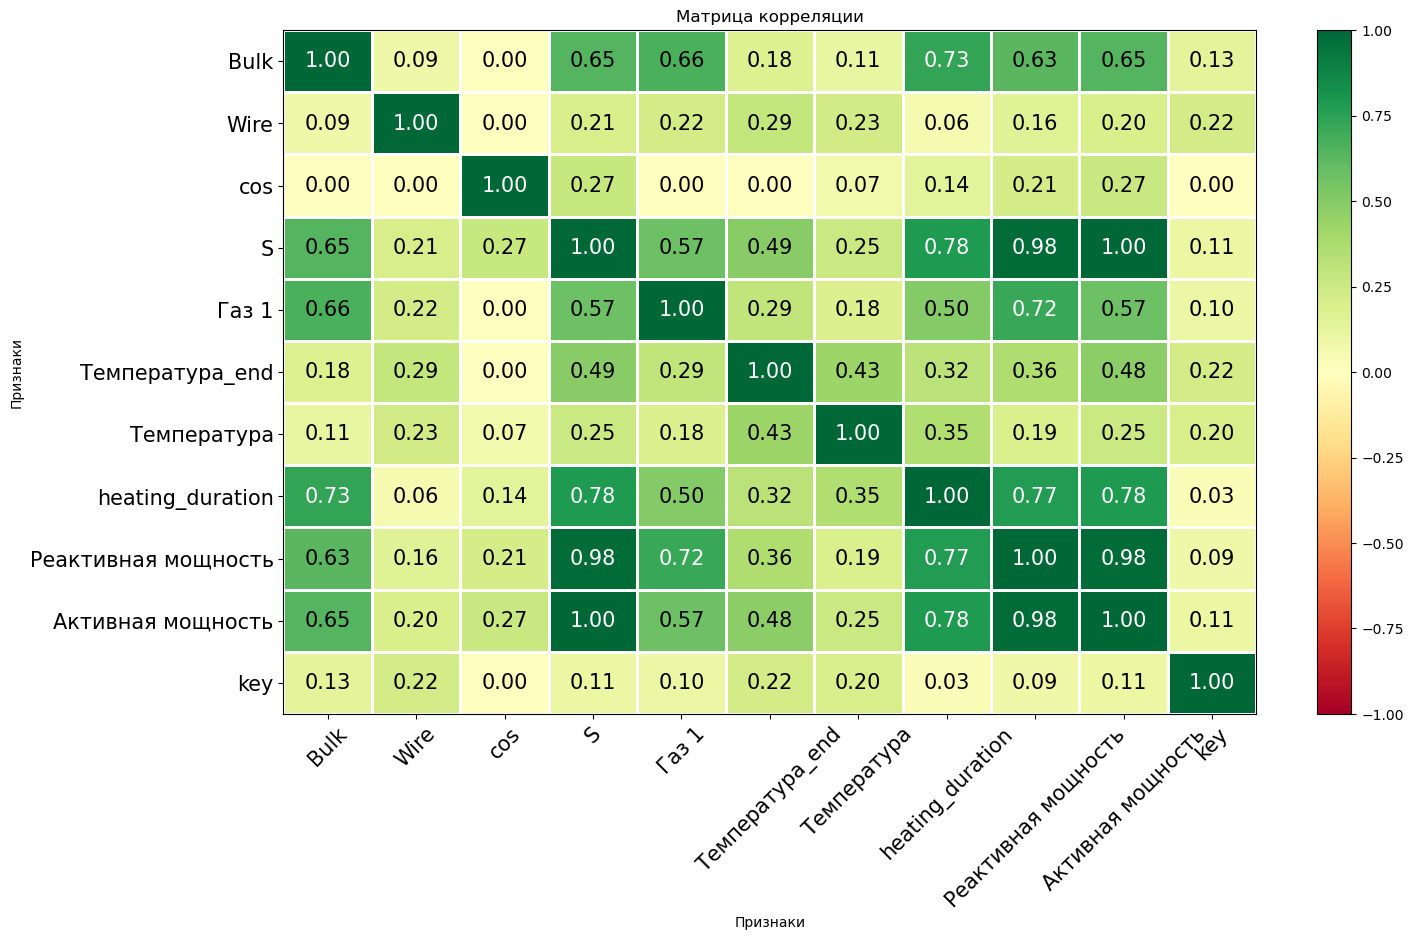

In [109]:
# список интервальных признаков
interval_cols = data.select_dtypes(include='number').columns.tolist()
# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = data.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plt.figure(figsize=(15,15))
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 10)
)
plt.title('Матрица корреляции')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.xticks(rotation=45)
plt.show()

Корреляция признаков:
- Газ 1 с Bulk 0.67
- Конечная температура с Wire 0.49
- Конечная температура с начальной температурой 0.57
Мультиколлинеарности не обнаружено

In [110]:
data.head(2)

,key,Активная мощность,Реактивная мощность,heating_duration,Температура,Температура_end,Газ 1,S,cos,Wire,Bulk
0,1,3.04,2.14,1098.0,1571.0,1613.0,29.749986,3.717687,0.817713,60.059998,553.0
1,2,2.14,1.45,811.0,1581.0,1602.0,12.555561,2.584976,0.827861,96.052315,582.0


## Подготовка данных

In [111]:
data.columns

Index(['key', 'Активная мощность', 'Реактивная мощность', 'heating_duration',
       'Температура', 'Температура_end', 'Газ 1', 'S', 'cos', 'Wire', 'Bulk'],
      dtype='object')

In [112]:
X = data.drop(['Температура_end','key', 'Активная мощность','cos','S'], axis=1)
y = data['Температура_end']

In [113]:
# разделение датасета на выборки с учётом дисбаланса
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
    )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1743, 6), (582, 6), (1743,), (582,))

In [114]:
X.columns

Index(['Реактивная мощность', 'heating_duration', 'Температура', 'Газ 1',
       'Wire', 'Bulk'],
      dtype='object')

In [115]:
# создаём списки с названиями признаков

# признаки для масштабирования
num_columns = ['heating_duration','Температура', 'Газ 1', 'Wire', 'Bulk','Реактивная мощность']

# создаём общий пайплайн для подготовки данных
# (объединение шагов подготовки)
data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), num_columns)# масштабирование num_columns
    ], 
    remainder='passthrough'# не применять шаги к данным вне списков
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
    ]
)
# print(ohe_pipe)
print('____________________________________________________')
print(data_preprocessor)
print('____________________________________________________')
print(pipe_final)

____________________________________________________
ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['heating_duration', 'Температура', 'Газ 1',
                                  'Wire', 'Bulk', 'Реактивная мощность'])])
____________________________________________________
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['heating_duration',
                                                   'Температура', 'Газ 1',
                                                   'Wire', 'Bulk',
                                                   'Реактивная мощность'])])),
                ('models', LinearRegression())])


In [116]:
transformed_train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
transformed_train[:3]

array([[-0.12937288,  0.6038998 ,  1.41701001,  1.26180133,  1.17794509,
         1.79766895],
       [-0.05352951,  0.64573927, -0.79220113,  0.50174161, -0.10340728,
         0.31579649],
       [-0.48817037, -0.7349632 , -0.29404575, -0.55823532, -0.34212498,
        -1.11119179]])

In [117]:
param_grid = [
# словарь для модели LinearRegression()
    {
      'models': [LinearRegression()],
      'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
        
    },


# словарь для модели SVR
    {
      'models': [SVR(epsilon=0.2)],
      'models__kernel': ['linear', 'rbf'],
      'models__degree': range(2, 3),
      'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
     },
# словарь для модели RandomForestRegressor
    {
    'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
    'models__max_depth' : range(5, 10),
    'models__n_estimators': [50, 100, 200, 500],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
    },
    
    
# словарь для модели KNeighborsRegressor  
    {
      'models': [KNeighborsRegressor()],
      'models__n_neighbors': range(1, 20),
      'models__leaf_size' : range(1, 100),  
      'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']   
    },
    
# словарь для модели SGDRegressor()    

    {
        'models': [SGDRegressor(random_state=RANDOM_STATE, alpha=0.0001, l1_ratio=0.0001)],
        'models__penalty': ['elasticnet','l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
  
    
]

## Обучение моделей машинного обучения

Обучите как минимум две модели. Хотя бы для одной из них подберите как минимум два гиперпараметра.

In [118]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=100,
    scoring= 'neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

In [119]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['heating_duration',
                                                                                'Температура',
                                                                                'Газ '
                                                                                '1',
                                                                                'Wire',
                                                                                'Bulk',
                                                                                'Реактивная '
                                                                                'мощность'])])),
                                             ('models', LinearRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'models': [LinearRegressi...
                                         'models__n_neighbors': range(1, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SGDRegressor(l1_ratio=0.0001,
                                                                 random_state=251124)],
                                         'models__penalty': ['elasticnet',
                                                             'l2'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=251124, scoring='neg_mean_absolute_error')

In [120]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['heating_duration',
                                                   'Температура', 'Газ 1',
                                                   'Wire', 'Bulk',
                                                   'Реактивная мощность'])])),
                ('models',
                 RandomForestRegressor(max_depth=7, n_estimators=50,
                                       random_state=251124))])


In [121]:
print ('Метрика лучшей модели на кросс-валидации:', round(randomized_search.best_score_*(-1),2))

Метрика лучшей модели на кросс-валидации: 6.85


Лучшая модель `RandomForestRegressor`   
Параметры модели:   
'models__max_depth': 7
'n_estimators': 50
Метрика лучшей модели на кросс-валидации: **6.85**

## Выбор лучшей модели

In [122]:
# вывод параметров лучшей модели
result = pd.DataFrame(randomized_search.cv_results_)

# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)

display(result[
    ['rank_test_score', 'mean_fit_time', 'mean_score_time', 'mean_test_score','param_models','params']
].sort_values('rank_test_score'))

,rank_test_score,mean_fit_time,mean_score_time,mean_test_score,param_models,params
10,1,0.327212,0.007290,-6.853421,RandomForestRegressor(random_state=251124),"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 50, 'models__max_depth': 7, 'models': RandomForestRegressor(random_state=251124)}"
23,2,0.380747,0.004787,-6.884382,RandomForestRegressor(random_state=251124),"{'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 100, 'models__max_depth': 6, 'models': RandomForestRegressor(random_state=251124)}"
72,3,0.007939,0.009922,-7.040821,KNeighborsRegressor(),"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 10, 'models__leaf_size': 86, 'models': KNeighborsRegressor()}"
35,4,0.006365,0.009726,-7.046426,KNeighborsRegressor(),"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 13, 'models__leaf_size': 85, 'models': KNeighborsRegressor()}"
64,4,0.006888,0.010248,-7.046426,KNeighborsRegressor(),"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 13, 'models__leaf_size': 22, 'models': KNeighborsRegressor()}"
...,...,...,...,...,...,...
96,96,0.007019,0.007312,-9.365530,KNeighborsRegressor(),"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 1, 'models__leaf_size': 37, 'models': KNeighborsRegressor()}"
80,96,0.006952,0.007159,-9.365530,KNeighborsRegressor(),"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 1, 'models__leaf_size': 27, 'models': KNeighborsRegressor()}"
29,96,0.006089,0.006306,-9.365530,KNeighborsRegressor(),"{'preprocessor__num': MinMaxScaler(), 'models__n_neighbors': 1, 'models__leaf_size': 83, 'models': KNeighborsRegressor()}"
78,99,0.005394,0.004497,-9.802536,KNeighborsRegressor(),"{'preprocessor__num': 'passthrough', 'models__n_neighbors': 1, 'models__leaf_size': 3, 'models': KNeighborsRegressor()}"


In [123]:
y_test_pred = randomized_search.predict(X_test)

In [124]:
# сохранение предсказанных и валидационных значений в датафрейм т
predictions = pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})
# трансформируем данные возведя в степень, чтобы прийти к исходным значениям температуры
predictions['y_test'] = predictions['y_test'] 
predictions['y_test_pred'] = predictions['y_test_pred']

predictions.head()

,y_test,y_test_pred
1276,1588.0,1588.669948
1181,1587.0,1592.912546
407,1599.0,1592.761649
1344,1594.0,1594.066608
1339,1597.0,1599.782674


In [125]:
test = predictions['y_test']
pred = predictions['y_test_pred']

In [126]:
print(f'Метрика mae на тестовой выборке: {round(mean_absolute_error(y_test, y_test_pred),2)}') 

Метрика mae на тестовой выборке: 6.67


In [127]:
model = randomized_search.best_estimator_.named_steps['models']
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, random_state=251124)

In [128]:
y_pred1 = model.predict(X_test)

In [129]:
X_test.iloc[0,] #val_features

Реактивная мощность       1.610000
heating_duration        944.000000
Температура            1554.000000
Газ 1                     9.512611
Wire                    205.091110
Bulk                    525.000000
Name: 1276, dtype: float64

In [130]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

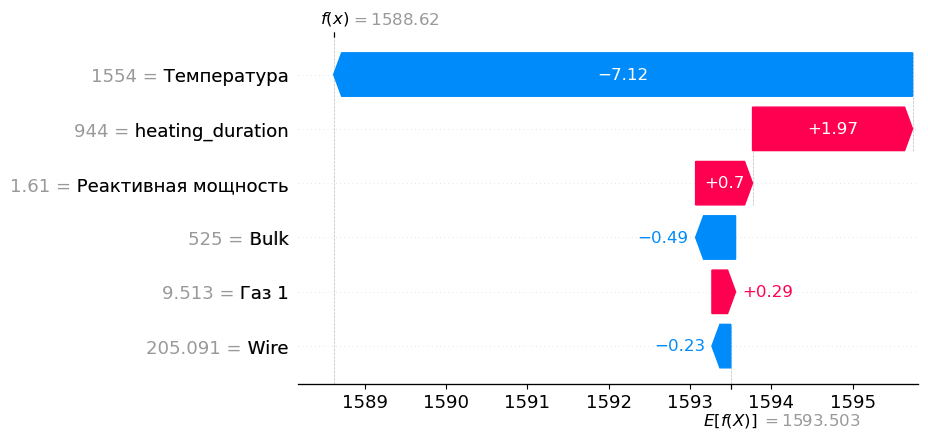

In [131]:
shap.plots.waterfall(shap_values[0])

In [132]:
shap.initjs()
shap.plots.force(shap_values[0])

In [133]:
shap.plots.force(shap_values[:200])

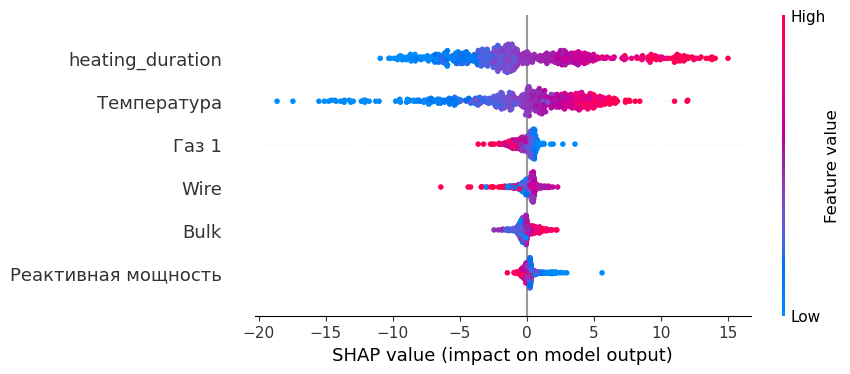

In [134]:
shap.plots.beeswarm(shap_values)

Метрика mae на тестовой выборке модели `DecisionTreeRegressor` 5.41.   
Метрика удовлетворяет требованиям заказчика менее 6.8.  
На температуру на выходе модели сильнее всего влияет температура на ее входе.   
Также имеют сильное влияние объем подаваемых проволочных материалов, что логично их тоже нужно растворить и на это затрачивается энергия.

### Выделение признаков в соответствии с графиком shap

<Axes: >

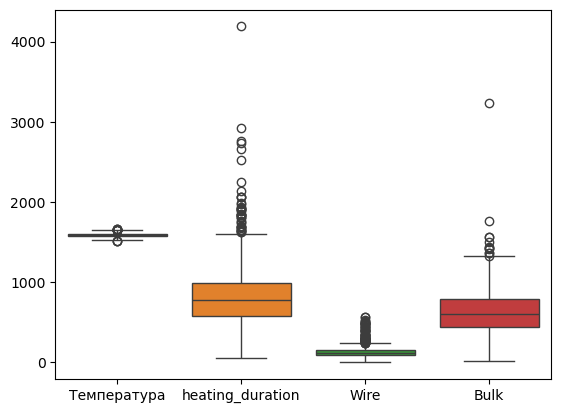

In [135]:
sns.boxplot(data=data[['Температура','heating_duration', 'Wire', 'Bulk']])

In [136]:
data.columns

Index(['key', 'Активная мощность', 'Реактивная мощность', 'heating_duration',
       'Температура', 'Температура_end', 'Газ 1', 'S', 'cos', 'Wire', 'Bulk'],
      dtype='object')

In [137]:
# выделение признаков в соответствии с графиком shap
features = ['Температура','heating_duration', 'Wire', 'Bulk']

target = 'Температура_end'

In [138]:
data_train, data_val = train_test_split(data, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [139]:
params = { 'max_depth':7,
           'n_estimators' : 50,
           'random_state':251124}

In [140]:
model = RandomForestRegressor(**params)

In [141]:
model.fit(data_train[features],data_train[target])

RandomForestRegressor(max_depth=7, n_estimators=50, random_state=251124)

In [142]:
y_pred = model.predict(data_val[features])

In [143]:
# сохранение предсказанных и валидационных значений в датафрейм т
pred = pd.DataFrame({'y_test': y_test, 'y_test_pred': y_pred})
# трансформируем данные возведя в степень, чтобы прийти к исходным значениям температуры
pred['y_test'] = pred['y_test']
pred['y_test_pred'] = pred['y_test_pred']

pred.head()

,y_test,y_test_pred
1276,1588.0,1586.401493
1181,1587.0,1592.636297
407,1599.0,1592.537355
1344,1594.0,1593.620388
1339,1597.0,1600.301102


In [144]:
mae = round(mean_absolute_error(pred['y_test'], pred['y_test_pred']),2)
mae

6.73

## Общий вывод и рекомендации заказчику

Получены фремы с данными data_arc_new.csv — данные об электродах;  
data_bulk_new.csv — данные о подаче сыпучих материалов (объём);  
data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);  
data_gas_new.csv — данные о продувке сплава газом;  
data_temp_new.csv — результаты измерения температуры;  
data_wire_new.csv — данные о проволочных материалах (объём);  
data_wire_time_new.csv — данные о проволочных материалах (время).  

Получен датафрейм **данных об электродах** 

- `key`                   int64  
- `Начало нагрева дугой`  object 
- `Конец нагрева дугой`   object 
- `Активная мощность`     float64
- `Реактивная мощность`   float64

В данных нет пропусков.  
Распределение данных по численным признакам нормальное, с выраженным правым хвостом.   
Начало нагрева дугой и конец нагрева дугой преобразовали в тип данных datetime64 и создали новый столбец длительность нагрева дугой(heating_duration).   
У получившихся данных по длительности нагрева распределение нормальное с правым хвостом.

Получен датафрейм `data_bulk_new`
Типы данных датафрейма 
key int64    
Bulk 1float64;  
Bulk 2 float64;  
Bulk 3 float64;  
Bulk 4 float64;  
Bulk 5 float64;  
Bulk 6 float64;  
Bulk 7 float64;  
Bulk 8 float64;  
Bulk 9 float64;  
Bulk 10 float64;  
Bulk 11 float64;  
Bulk 12 float64;  
Bulk 13 float64;  
Bulk 14 float64;  
Bulk 15 float64.  

Bulk1-Bulk 15 типы присадок, если присадку не добавляли в данный момент времени, значит она не нужна, поэтому заменим не числовы значения 0.  В данных о сыпучих материалах есть выбросы на мой взгляд они не критичны на этом этапе оставим данные без изменений. Т.к. может быть что на этапе добавления присадок нужен был больший объем для нормализации химического состава.

Получен датафрейм о продувке сплава газом `data_gas_new`
key int64;  
Газ 1 float64.  

Продувка используется в том числе для перемешивания смеси.   
Данные распределены нормально в данных есть выбросы, на данном этапе оставим их без изменения.

Получены данные об измерениях температуры data_wire_time_new
Типы данных
key        int64;  
Wire 1    object;  
Wire 2    object;  
Wire 3    object;  
Wire 4    object;  
Wire 5    object;  
Wire 6    object;  
Wire 7    object;  
Wire 8    object;  
Wire 9    object.  

Если есть измерение конечной температуры, значит исследуемый материал достиг целевого химического состава и оптимальной температуры, т.е. пригоден для производства готового продукта заготовки-сляба.  Следовательно нас интересует только начальное измерение температуры и конечное измерение в качестве целевого признака.

С помощью pipeline исследованны разные модели, получена лучшая модель `RandomForestRegressor`(random_state=251124) 

- 'preprocessor__num': StandardScaler()  
- 'models__n_estimators': 50  
- 'models__max_depth': 7   

Метрика лучшей модели на кросс-валидации: 6.85  

Метрика mae на тестовой выборке модели `RandomForestRegressor` **6.67**.   
При уменьшении признаков в соответствии с  графиком shap метрика mae становится 6.73    
Выбрали метрику mae, т.к. она более устойчива к выбросам, которых у нас не мало. Метрика удовлетворяет требованиям заказчика менее __6.8__. 

На температуру на выходе модели сильнее всего влияет температура на ее входе. 
При подборе оптимальной температуры плавления стали на входе равной 1554 градусам, затраты на электроэнергию уменьшаться, за счет снижения числа итераций при изготовлении слябов.